In [ ]:
"""
%pip install qiskit==2.1.2
%pip install qiskit-ibm-runtime==0.41.1
%pip install qiskit-aer==0.17.2
%pip install pylatexenc
"""

'\n%pip install qiskit==2.1.2\n%pip install qiskit-ibm-runtime==0.41.1\n%pip install qiskit-aer==0.17.2\n%pip install pylatexenc\n'

In [ ]:
from qiskit_aer.noise import NoiseModel, depolarizing_error, pauli_error
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.visualization import plot_histogram
from qiskit.quantum_info import  Statevector
from qiskit_aer import AerSimulator
from qiskit import transpile
from math import pi

# Overview

In this Jupyter notebook, we will implement the code [[4, 2, 2]]. This code uses two original qubits and creates two logical qubits, using a total of four qubits. The difference between this version and the three-qubit code is that, in addition to creating two logical qubits, this code will be able to detect not only bit flips but also phase flips.

The only limitation of this new version is that, given the code distance d=2, it will not be possible to identify which qubit the error occurred in. Therefore, it will not be possible to apply error correction, and the code [[4, 2, 2]] is only an error detection code. Due to the anticommutation properties of stabilizers, if two or four errors of the same nature occur (bit flip or phase flip), the error will not be detected and will not generate any syndromes.

# 1°: Create the Noisy Model

Again, we'll create a noisy quantum circuit model with an adjustable probability of an error occurring in any of the selected gates. These errors will affect the two original qubits as well as the redundancy qubits that will be used to create the logical qubits. To account for errors, the noisy model will not be applied to the ancilla qubits. This means that any changes that occur in the ancilla qubits will be due solely and exclusively to the errors that occurred in the logical qubits.

In [ ]:
noise_model = NoiseModel()
p_error_1q = 0.2
noisy_gates = ['id','x','y','z','h']
error_1q = depolarizing_error(p_error_1q, 1)
noise_model.add_quantum_error(error_1q,  noisy_gates, [0])
noise_model.add_quantum_error(error_1q, noisy_gates, [1])
noise_model.add_quantum_error(error_1q, noisy_gates, [2])
noise_model.add_quantum_error(error_1q, noisy_gates, [3])

# 2°: Create the Stabilizer Gates

Stabilizers are operators responsible for anti-commuting with errors introduced into the logical state. Consequently, these anti-commutations cause the ancilla qubits to signal the error in the logical state. With enough qubits, however, it is possible not only to detect but also to correct. In this section, we will create the stabilizers responsible for detecting errors in the logical state. The only possible stabilizers for the code [[4, 2, 2]] are Z1Z2Z3Z4 and X1X2X3X4. For each combination of ancilla qubit results, we will have a possible error associated with the logical state being signaled. Below, we summarize some of these possible signals and their respective meanings:



*   00: No error occurred and the logical state is intact;
*   01: An error of nature X1, X2, X3 or X4 occurred in the logical state;
*   10: An error of nature Z1, Z2, Z3 or Z4 occurred in the logical state;
*   11: An error of nature Y1, Y2, Y3, or Y4 occurred in the logical state.

In [ ]:
# X1X2X3X4 Stabilizer Gate Creation
qr = QuantumRegister(4)
qc = QuantumCircuit(qr)
qc.x(qr[:])
qc.draw("mpl")
stabilizer1 = qc.to_gate(label="X1X2X3X4").control(1)

In [ ]:
# Z1Z2Z3Z4 Stabilizer Gate Creation
qr = QuantumRegister(4)
qc = QuantumCircuit(qr)
qc.z(qr[:])
qc.draw("mpl")
stabilizer2 = qc.to_gate(label="Z1Z2Z3Z4").control(1)

# 3°: Create the Quantum Circuit For the Four Qubit Code

As stated previously, the [[4,2,2]] code requires 4 qubits to encode 2 logical qubits with distance equal to 2. In the code cell below, we create the quantum circuit required for the [[4,2,2]] code. We divide the quantum circuit into three steps: initialization of the original qubits (original information), encoder step, and syndrome extraction. We divide the last step into two separate code cells to visualize the state of the information.

In [ ]:
q_psi = QuantumRegister(2, 'Ψ')
q_red = QuantumRegister(2, 'r')
q_anc = QuantumRegister(2, 'A')
c_log = ClassicalRegister(4, 'l')
c_anc = ClassicalRegister(2, 'a')
circuit = QuantumCircuit(q_psi, q_red, q_anc, c_log, c_anc)

# Physical Creation
circuit.barrier(label="Psi1 Ps2 Initialization")

# Encoder Procedure
circuit.cx(0, 2)
circuit.cx(1, 2)
circuit.h(3)
circuit.cx(3, 2)
circuit.cx(3, 1)
circuit.cx(3, 0)
circuit.barrier(label="Enconder")

# Syndrome Extraction
circuit.h(q_anc[:])
circuit.append(stabilizer1, [4,0,1,2,3])
circuit.append(stabilizer2, [5,0,1,2,3])
circuit.h(q_anc[:])
circuit.draw("mpl")

In [ ]:
state = Statevector(circuit)
state.draw("latex")

<IPython.core.display.Latex object>

# 4°: Syndrome Extraction Conclusion

In this step, we proceed to the final stage of syndrome extraction by measuring the ancilla qubits. Once this step is complete, we can detect errors through the ancilla qubits.

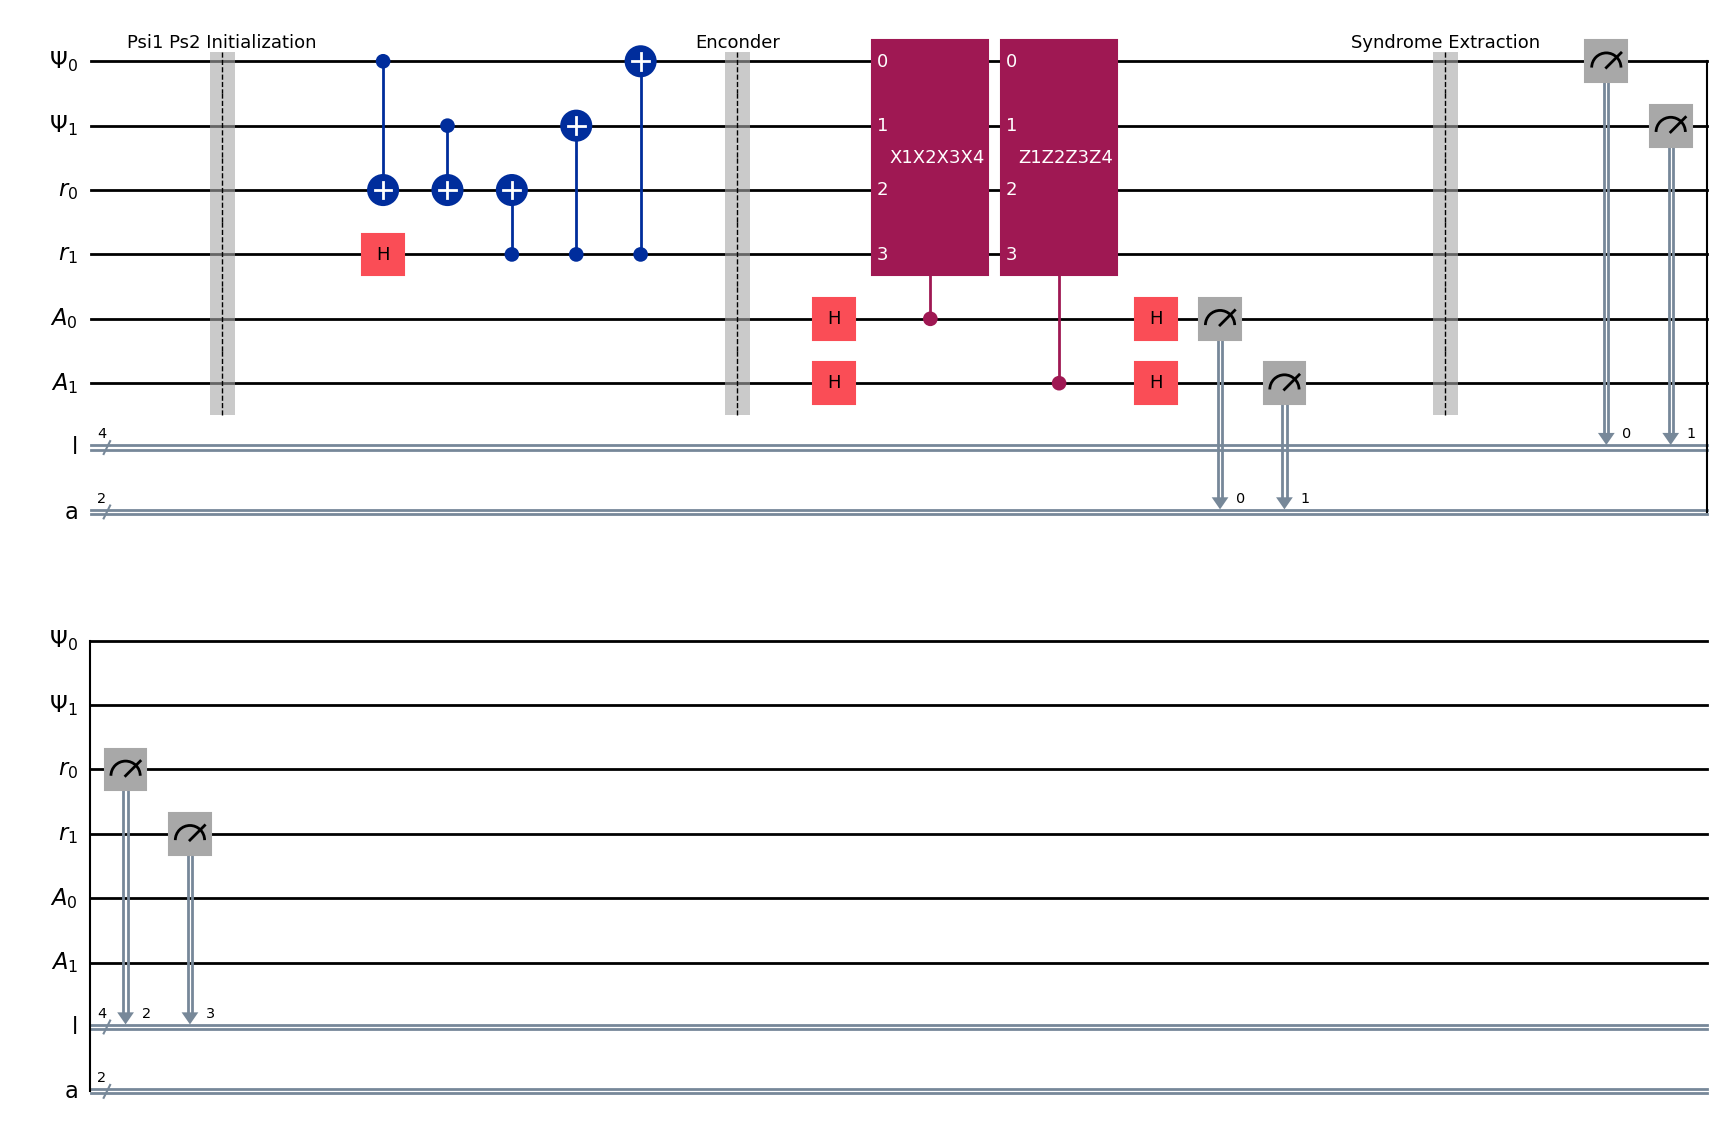

In [ ]:
circuit.measure(q_anc[0], c_anc[0])
circuit.measure(q_anc[1], c_anc[1])
circuit.barrier(label="Syndrome Extraction")
circuit.measure(q_psi[0], c_log[0])
circuit.measure(q_psi[1], c_log[1])
circuit.measure(q_red[0], c_log[2])
circuit.measure(q_red[1], c_log[3])

circuit.draw("mpl")

# 5°: Results View

At the end of this notebook, we ran the quantum circuit in a noisy model. We ran the circuit 1024 times by default. Because we have two custom gates, we need to transpile the quantum circuit to the Aer simulator. The results can be visualized in the cells below. Each ancilla qubit result has an error meaning that can be understood through the summary in step 2. Our goal, or holy grail, is to always obtain the cases in which the ancilla qubits return 00. Of course, as mentioned previously, correcting errors detected in the ancillas will not be possible due to code limitations.

In [ ]:
sim_noise = AerSimulator(noise_model=noise_model)
transpiled_circuit = transpile(circuit, sim_noise)
shots = 1024
run = sim_noise.run(transpiled_circuit, shots=shots)
counts = run.result().get_counts()

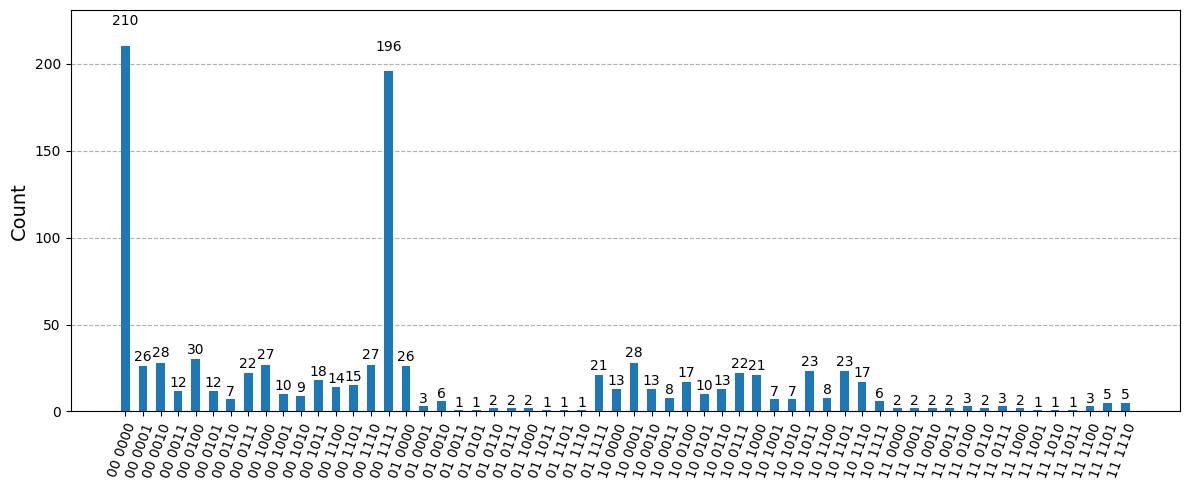

In [ ]:
plot_histogram(data=counts, figsize=(12,5))